### Super Resolution Proof of Concept (with MNIST) 

Goals: Convert low-res images to high-res images; 
Predict the high-res images from the low-res images 


In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pyresample
import os
import time
from IPython import display
import datetime 
import pathlib

2022-11-12 10:33:34.958251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-PCIE-40GB, compute capability 8.0


In [3]:
def to_tf_dataset(images, batch_size):
    # Create tf.data.Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

    return dataset

def get_high_and_low_res(images, batch_size=1): 
    # Resize from 28,28 to 32,32 for the downsampling/upsampling in the generator. 
    hr_images = tf.image.resize(images, [32, 32],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    lr_images = tf.image.resize(images, [16, 16],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    
    return to_tf_dataset((lr_images, hr_images), batch_size)

In [4]:
IMG_SHAPE = (28, 28, 1)

IMG_WIDTH_RESIZE = 32

mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5

# Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
test_images = test_images.reshape(test_images.shape[0], *IMG_SHAPE).astype("float32")
test_images = (test_images - 127.5) / 127.5

train_ds = get_high_and_low_res(train_images)
test_ds = get_high_and_low_res(test_images)

Number of examples: 60000
Shape of the images in the dataset: (28, 28)


2022-11-12 10:33:39.158009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-12 10:33:39.715181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38247 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


In [20]:
class SRCGAN:
    """
    Generator built off of a U-Net design. 
    
    Parameters
    ---------------------
    input_shape : array-like
    output_shape : array-like 
    """
    def __init__(self, input_shape, output_shape):
        self._input_shape = input_shape
        self._output_shape = output_shape
        self._num_channels = input_shape[-1]
        self._lambda = 100
        
        self.start_filter = 32 
        self.filters_ = [32, 64, 128]
        
        self.loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
        self.generator_ = self.generator()
        self.discriminator_ = self.discriminator()
        
        checkpoint_dir = './training_checkpoints'
        self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self._generator_optimizer,
                                 discriminator_optimizer=self._discriminator_optimizer,
                                 generator=self.generator_,
                                 discriminator=self.discriminator_)
        
        self.gen_total_loss = []
        self.gen_gan_loss = []
        self.gen_l1_loss = []
        self.disc_loss = [] 
        
    def downsample(self, filters, size, apply_batchnorm=True, use_bias=False):
        """
        Downsampling block. Block includes:
        1) Conv2D
        2) Activation 
        3) BatchNorm (optional)
        4) MaxPooling 
        
        Parameters
        -------------------------
        filters : integer 
            The number of convolution filters (dimensionality of the output space)
        
        size : integer 
            Height and Width of the 2D convolution window 
            
        apply_batchnorm : bool
            If True, add BatchNormalization 
        """
        initializer = tf.random_normal_initializer(0., 0.02)

        result = keras.Sequential()

        result.add(
            layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=use_bias)
        )
        
        if apply_batchnorm:
            result.add(layers.BatchNormalization())

        result.add(layers.LeakyReLU())
        
        #result.add(layers.MaxPooling2D())

        return result
    
    def upsample(self, filters, size, apply_dropout=False, apply_batchnorm=True, dropout=0.5):
        """
        Upsampling block. Block includes:
        1) Conv2DTranspose
        2) Activation 
        3) BatchNorm (optional)

        Parameters
        -------------------------
        filters : integer 
            The number of convolution filters (dimensionality of the output space)
        
        size : integer 
            Height and Width of the 2D convolution window 
            
        apply_batchnorm : bool
            If True, add BatchNormalization
        """    
        initializer = tf.random_normal_initializer(0., 0.02)

        result = keras.Sequential()
        result.add(
          layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
            
        if apply_batchnorm:
            result.add(layers.BatchNormalization())

        if apply_dropout:
            result.add(layers.Dropout(dropout))

        # TODO: Make activation changeable. 
        result.add(layers.ReLU())
            
        return result
    
    
    def generator(self):
        """
        The U-net-based generator model. 
        """
        kernel_size = 4
        
        self._generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        
        inputs = tf.keras.layers.Input(self._input_shape)

        # TODO: Determine the math to make this generally work! (downsampling and upsampling)
        
        down_filters = [32, 64, 128, 512]
        up_filters = [512] + down_filters[::-1] 
        batchnorm = [False, True, True, True]
        dropout = [True, True, False, False]
        
        # Apply the downsampling. 
        down_stack = [self.downsample(n, kernel_size, norm) for n, norm in zip(down_filters, batchnorm)]
        #(16, 16, 1)->(8,8,32)->(4,4,64)->(2,2, 128)->(1,1,512)
        
        # Apply the upsampling 
        up_stack = [self.upsample(n, kernel_size, apply_dropout=dropout)
                    for n, dropout in zip(up_filters, dropout)]   
        #(1,1,512)->(2,2,512)->(4,4, 128)->(8,8,64)->(16,16, 32)
        
        # Add the final layer. 
        initializer = tf.random_normal_initializer(0., 0.02)
        last = tf.keras.layers.Conv2DTranspose(self._num_channels, kernel_size,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  
        
        #(32, 32, 1)
        
        x = inputs

        # Downsampling through the model
        skips = []
        for down in down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            x = tf.keras.layers.Concatenate()([x, skip])

        # Add an additional upsample to produce high-res. 
        # TODO: This is ad-hoc at the moment as it only works
        # if the low-res is (x/2, y/2) of the high-res. 
        x = self.upsample(self._num_channels, kernel_size)(x) 
        x = last(x)

        return tf.keras.Model(inputs=inputs, outputs=x)
    
    def generator_loss(self, disc_generated_output, gen_output, target):
        """Compute the Generator Loss"""
        
        # Binary cross-entropy from a field of zeros. 
        gan_loss = self.loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

        # Mean absolute error
        target = tf.cast(target, tf.float16)
        gen_output = tf.cast(gen_output, tf.float16)
        
        l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

        total_gen_loss = gan_loss + (self._lambda * l1_loss)

        return total_gen_loss, gan_loss, l1_loss
    
    
    def discriminator(self):
        """
        Discriminator Model. The discriminator is a convolution PatchGAN classifier
        -- it tries to classify if each image patch is real or not real 
        (described in Isola et al. 2018; https://arxiv.org/abs/1611.07004). 
        
        1) Upsample the low-res image to the high-res image shape
        2) Concatenate the input image and a target high-res image
        3) Down sample to number of channels 

        """  
        kernel_size = 4
        self._discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        
        initializer = tf.random_normal_initializer(0., 0.02)

        inp = tf.keras.layers.Input(shape=self._input_shape, name='input_image')
        tar = tf.keras.layers.Input(shape=self._output_shape, name='target_image')
        
        # Upsample the low-res image to the high-res image output. 
        up_inp = self.upsample(1, 2, False)(inp)
        
        x = layers.concatenate([up_inp, tar])  # (batch_size, 32, 32, channels*2)

        down_filters = [32, 64, 128]
        down = self.downsample(down_filters[0], kernel_size, apply_batchnorm=False)(x)
        for n_filters in down_filters[1:]:
            down = self.downsample(n_filters, kernel_size, apply_batchnorm=True)(down)
            #(32, 32, 2)->(16,16, 32)->(8,8, 64)->(4,4, 128)
        
        #print(down.shape)->(4,4,128)
        
        zero_pad = layers.ZeroPadding2D()(down)
        # (4, 4, 128)->(6, 6, 128)
        
        down = self.downsample(512, kernel_size, apply_batchnorm=True)(zero_pad)
        # (6, 6, 128)->(3, 3, 512)
        
        zero_pad = layers.ZeroPadding2D()(down)
        
        last = layers.Conv2D(self._num_channels, kernel_size, strides=1,
                                kernel_initializer=initializer)(zero_pad)  
        #(3,3,128)->(3,3,1)
        
        return keras.Model(inputs=[inp, tar], outputs=last)
    
    def discriminator_loss(self, disc_real_output, disc_generated_output):
        real_loss = self.loss_object(tf.ones_like(disc_real_output), disc_real_output)

        generated_loss = self.loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss
    
    @tf.function
    def train_step(self, input_image, target, step):
        
        log_dir="logs/"

        summary_writer = tf.summary.create_file_writer(
        log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = self.generator_(input_image, training=True)

            disc_real_output = self.discriminator_([input_image, target], training=True)
            disc_generated_output = self.discriminator_([input_image, gen_output], training=True)

            gen_total_loss, gen_gan_loss, gen_l1_loss = self.generator_loss(disc_generated_output,
                                                                            gen_output, target)
            disc_loss = self.discriminator_loss(disc_real_output, disc_generated_output)

            generator_gradients = gen_tape.gradient(gen_total_loss,
                                          self.generator_.trainable_variables)
            
            discriminator_gradients = disc_tape.gradient(disc_loss,
                                               self.discriminator_.trainable_variables)

            self._generator_optimizer.apply_gradients(zip(generator_gradients,
                                          self.generator_.trainable_variables))
            
            self._discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              self.discriminator_.trainable_variables))

            self.gen_total_loss.append(gen_total_loss)
            self.gen_gan_loss.append(gen_gan_loss)
            self.gen_l1_loss.append(gen_l1_loss)
            self.disc_loss.append(disc_loss)
            
            #with summary_writer.as_default():
            #    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
            #    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
            #    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
            #    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)
    
    def generate_images(self, model, test_input, tar):
        prediction = model(test_input, training=True)
        plt.figure(figsize=(15, 15))

        display_list = [test_input[0], tar[0], prediction[0]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']

        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # Getting the pixel values in the [0, 1] range to plot.
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')

    def fit(self, train_ds, test_ds, steps):
        
        example_input, example_target = next(iter(test_ds.take(1)))
        start = time.time()

        for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
            if (step) % 1000 == 0:
                display.clear_output(wait=True)

                if step != 0:
                    print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

                start = time.time()

                self.generate_images(self.generator_, example_input, example_target)
                print(f"Step: {step//1000}k")

            self.train_step(input_image, target, step)

            # Training step
            if (step+1) % 10 == 0:
                print('.', end='', flush=True)


            # Save (checkpoint) the model every 5k steps
            #if (step + 1) % 5000 == 0:
            #    self.checkpoint.save(file_prefix=self.checkpoint_prefix)
            
    def predict(self, inp):
        return self.generator_(inp)
    
    def save(self,):
        pass
    

In [21]:
srcgan = SRCGAN(input_shape=(16, 16, 1), output_shape=(32,32,1))

In [22]:
srcgan.generator_.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 16, 16, 1)]  0           []                               
                                                                                                  
 sequential_28 (Sequential)     (None, 8, 8, 32)     512         ['input_3[0][0]']                
                                                                                                  
 sequential_29 (Sequential)     (None, 4, 4, 64)     33024       ['sequential_28[0][0]']          
                                                                                                  
 sequential_30 (Sequential)     (None, 2, 2, 128)    131584      ['sequential_29[0][0]']          
                                                                                            

In [23]:
srcgan.discriminator_.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 16, 16, 1)]  0           []                               
                                                                                                  
 sequential_37 (Sequential)     (None, 32, 32, 1)    8           ['input_image[0][0]']            
                                                                                                  
 target_image (InputLayer)      [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 concatenate_11 (Concatenate)   (None, 32, 32, 2)    0           ['sequential_37[0][0]',          
                                                                  'target_image[0][0]']     

Time taken for 1000 steps: 5.77 sec

Step: 39k
....................................................................................................

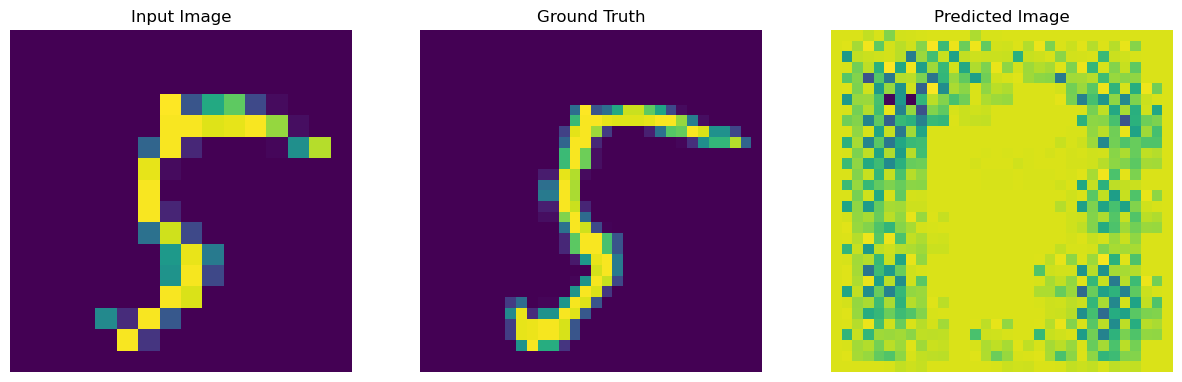

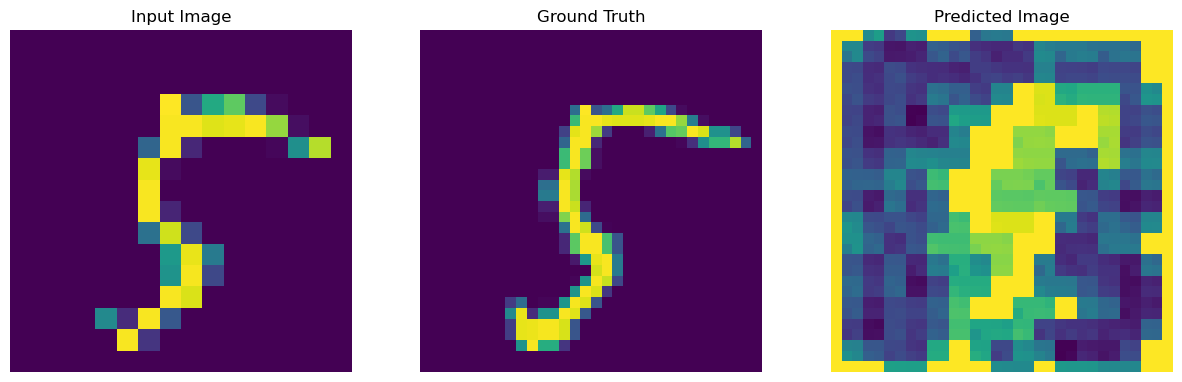

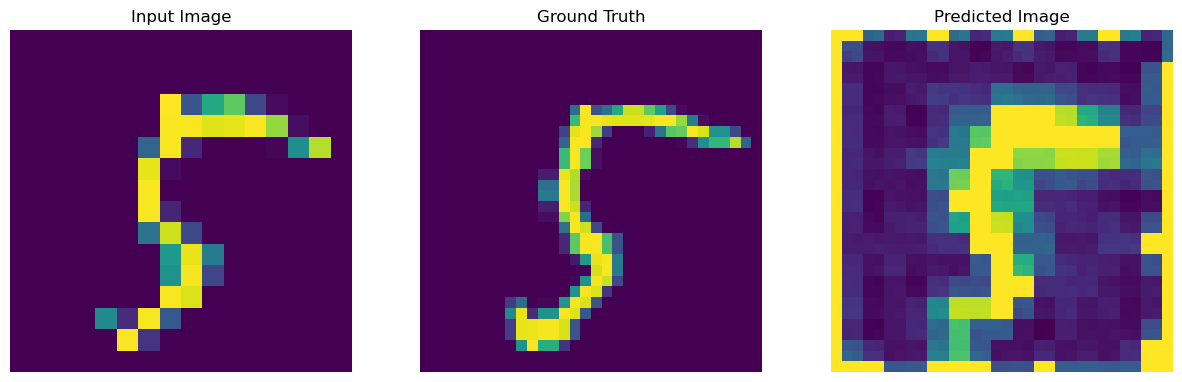

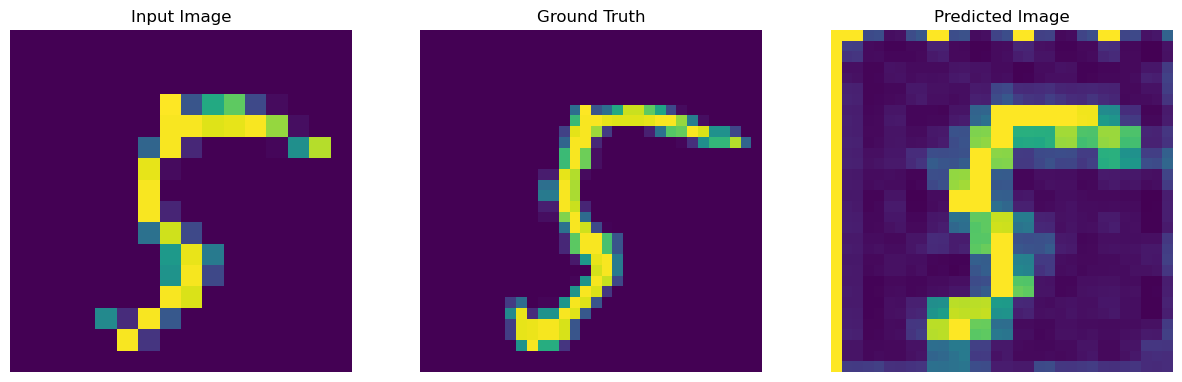

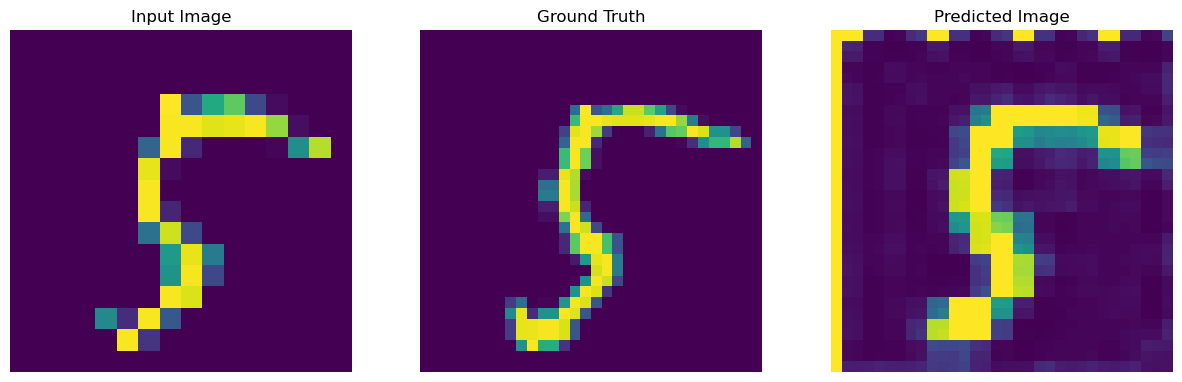

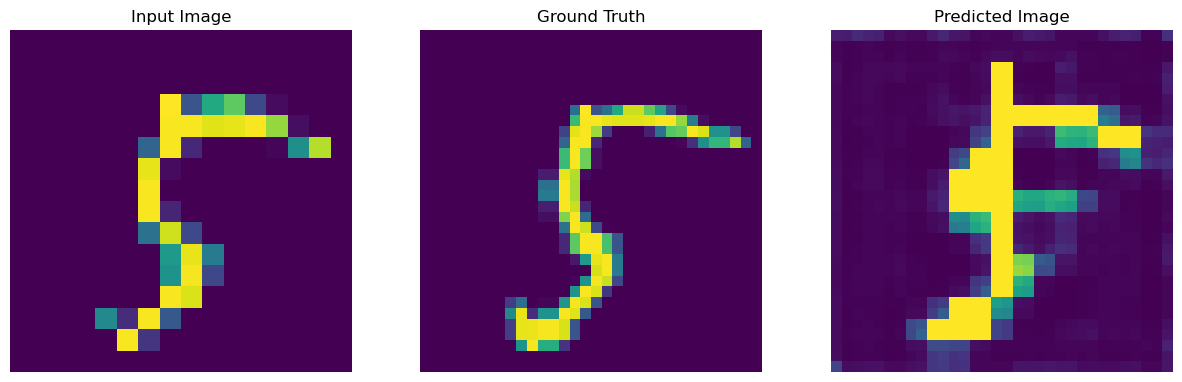

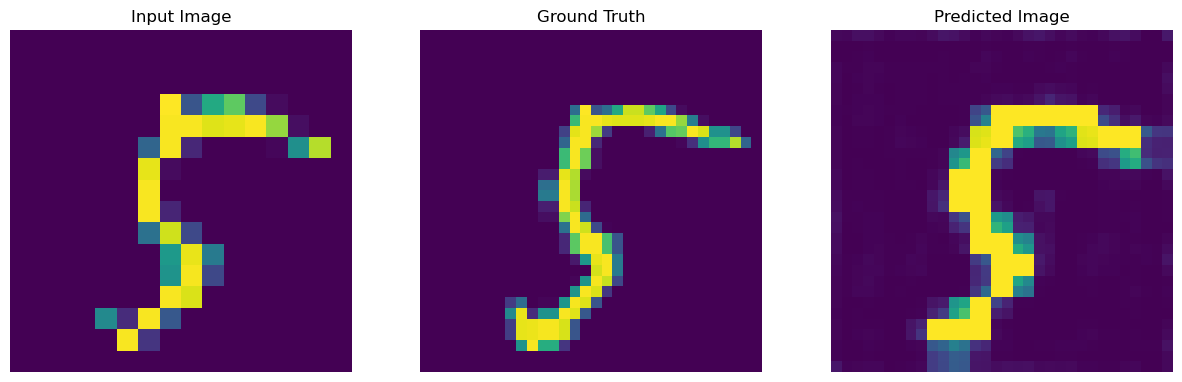

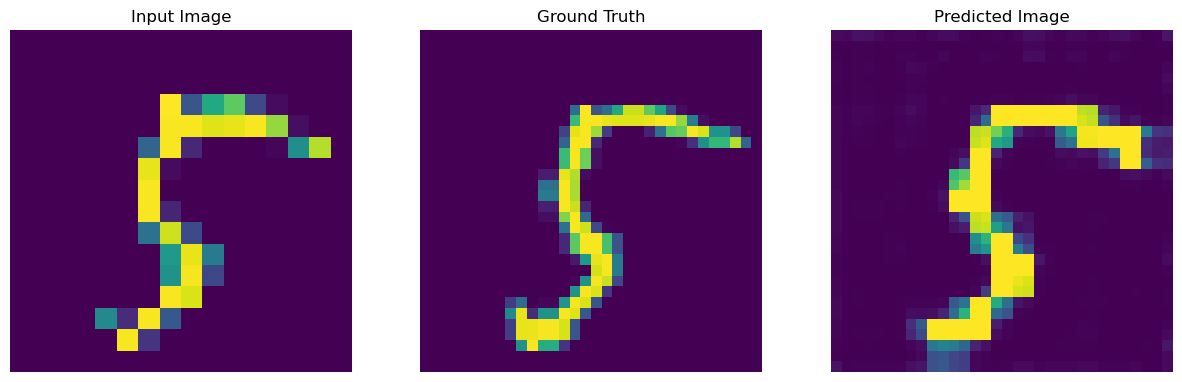

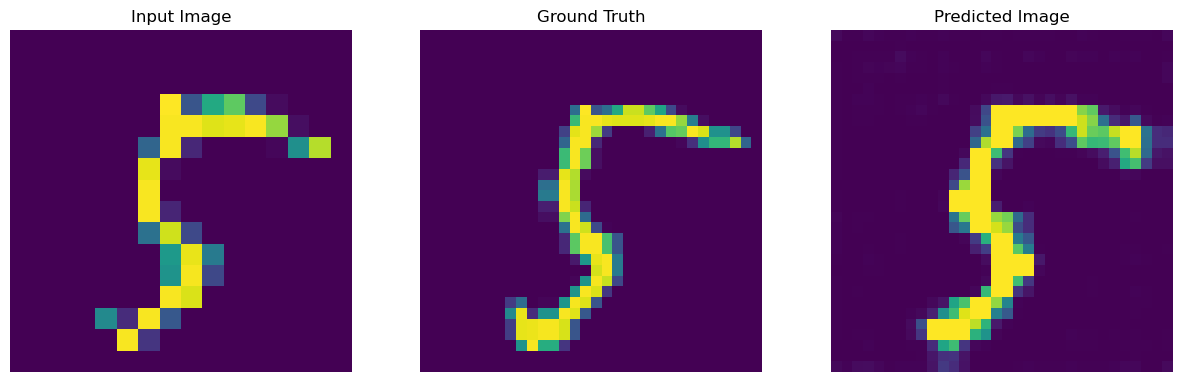

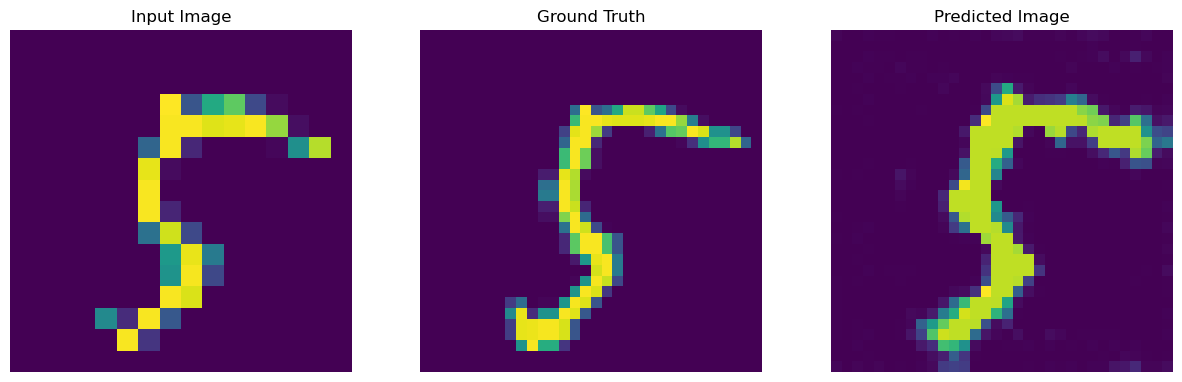

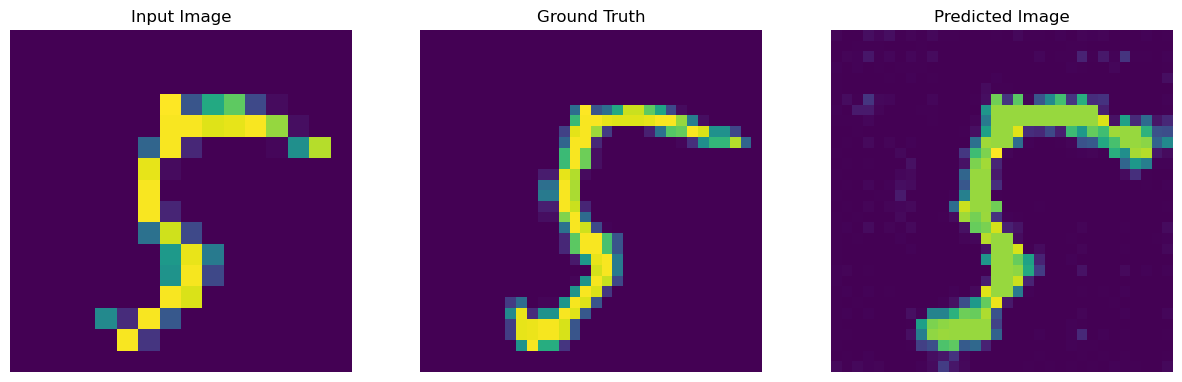

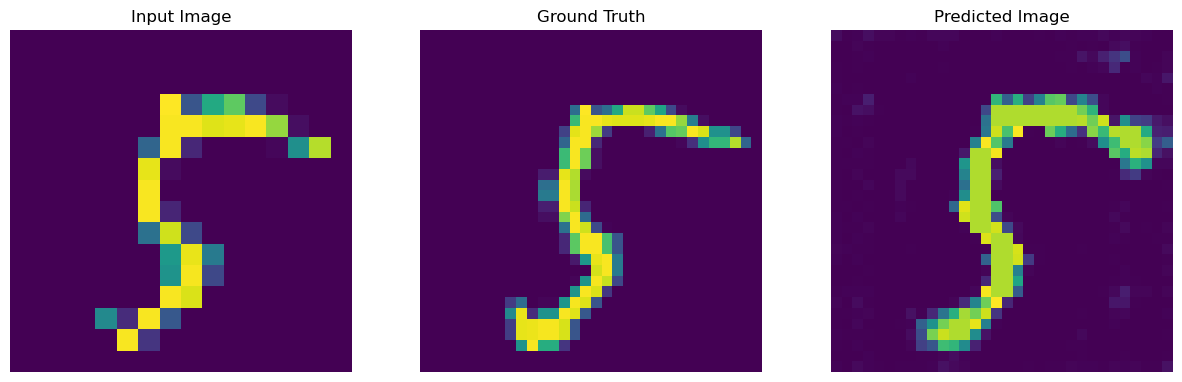

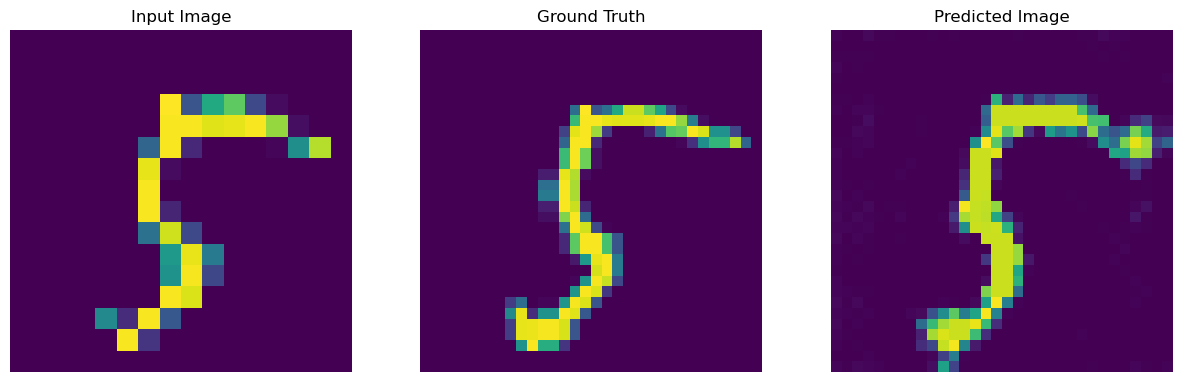

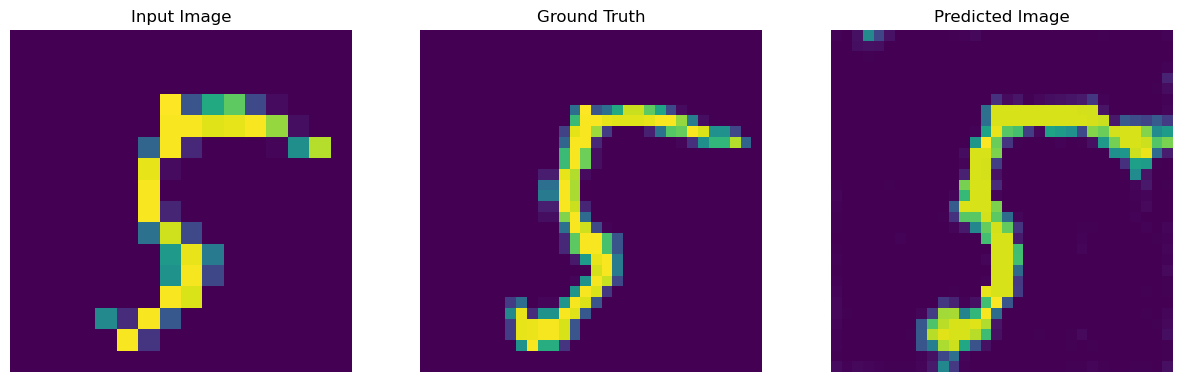

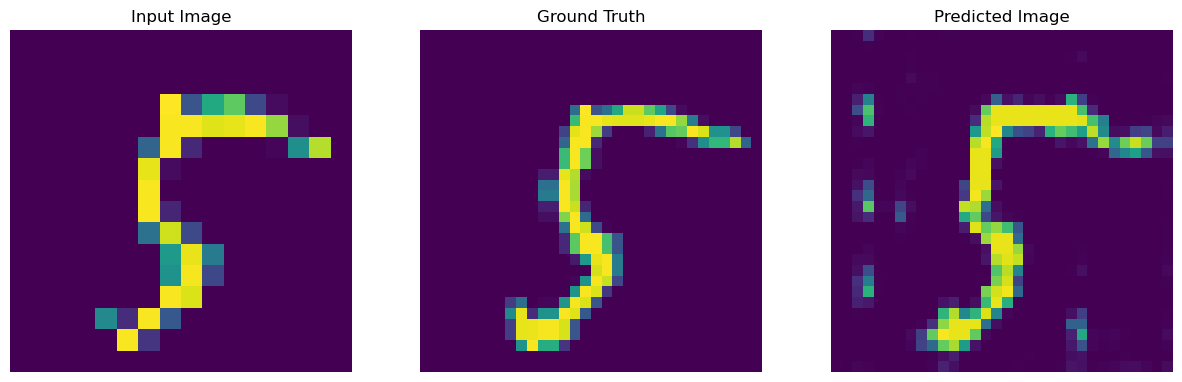

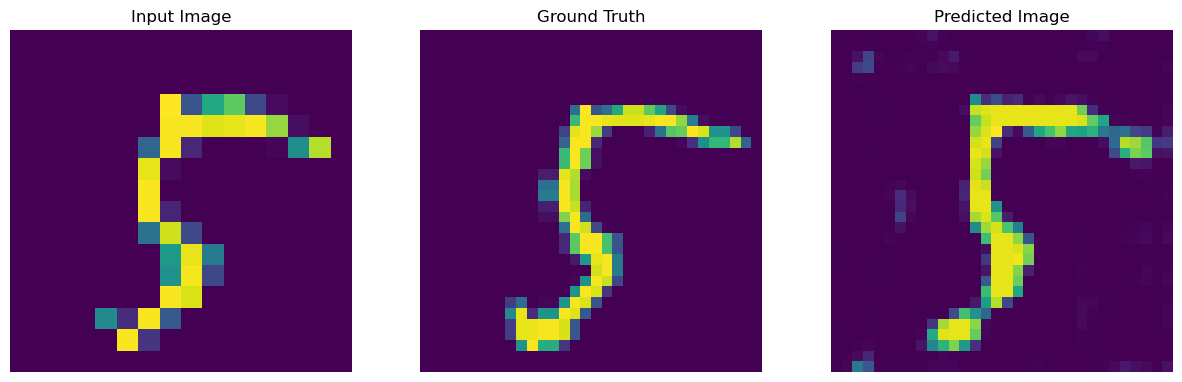

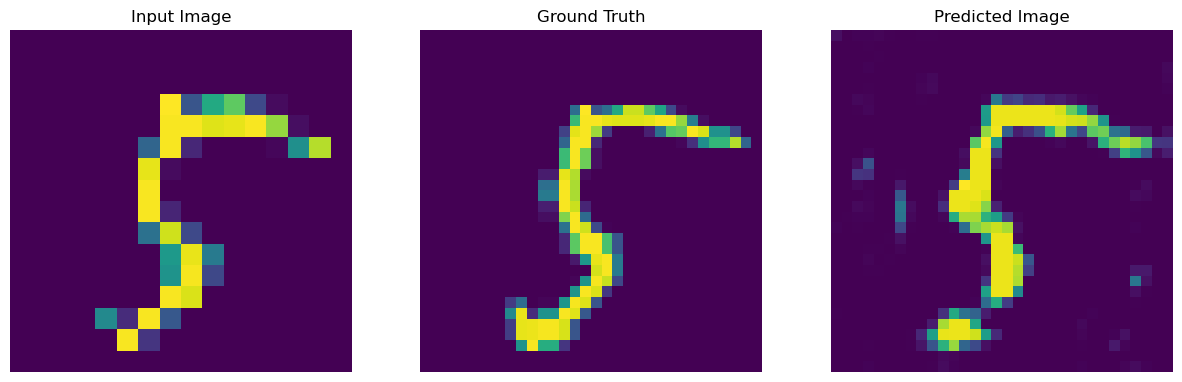

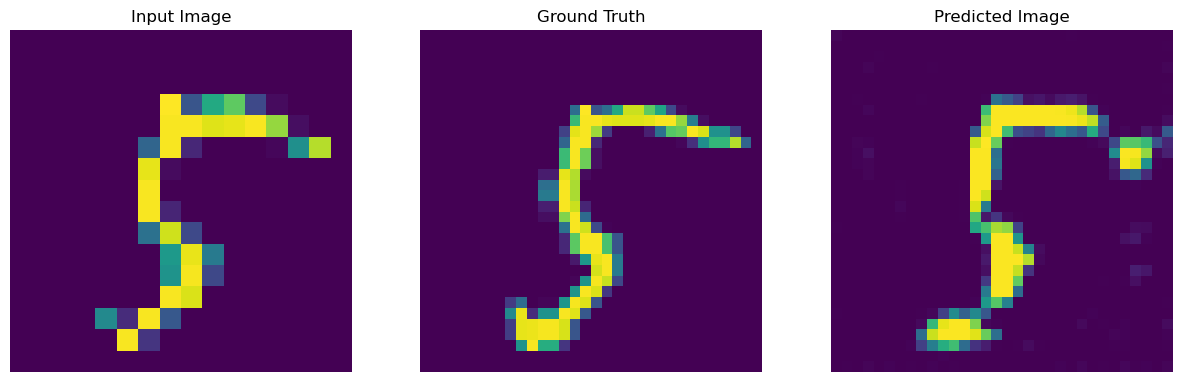

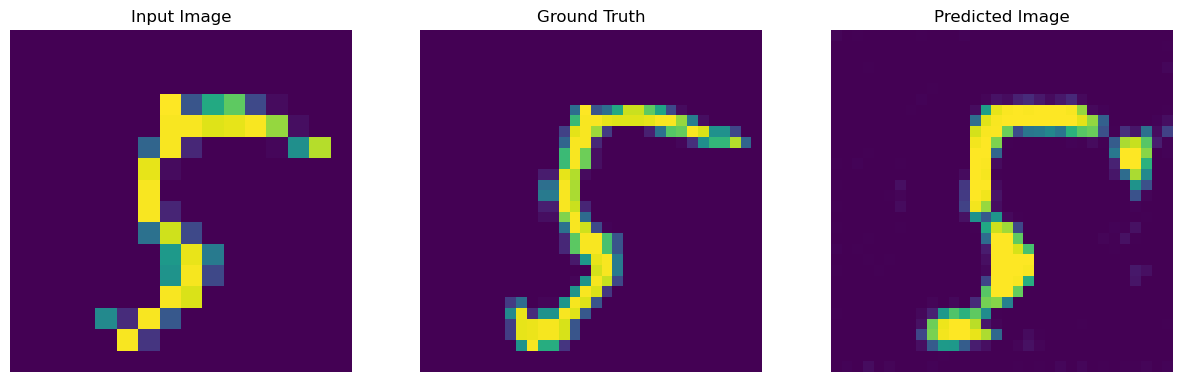

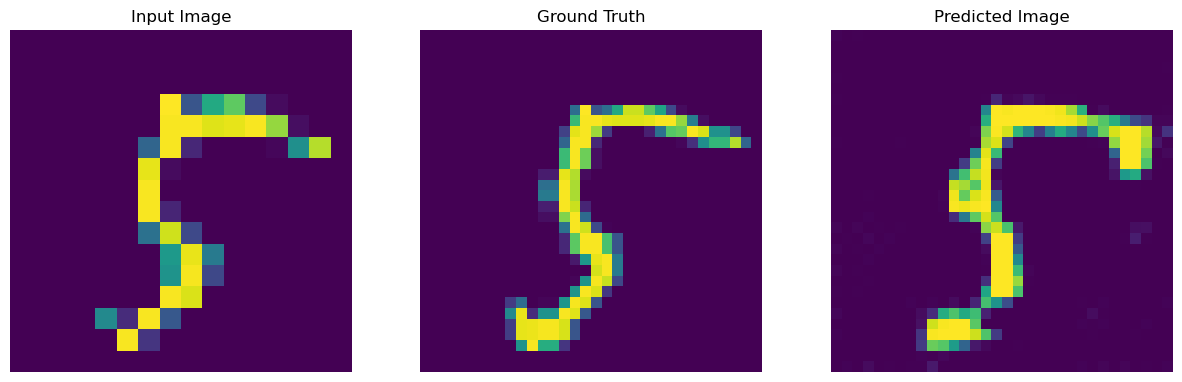

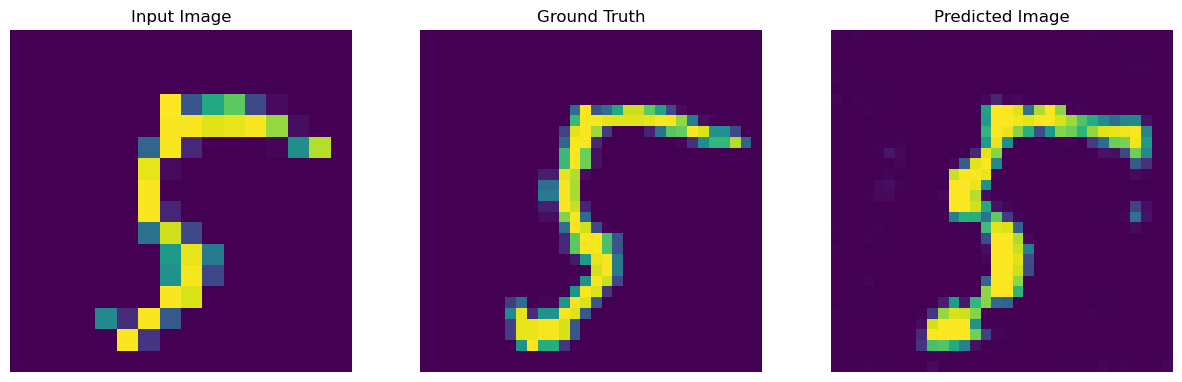

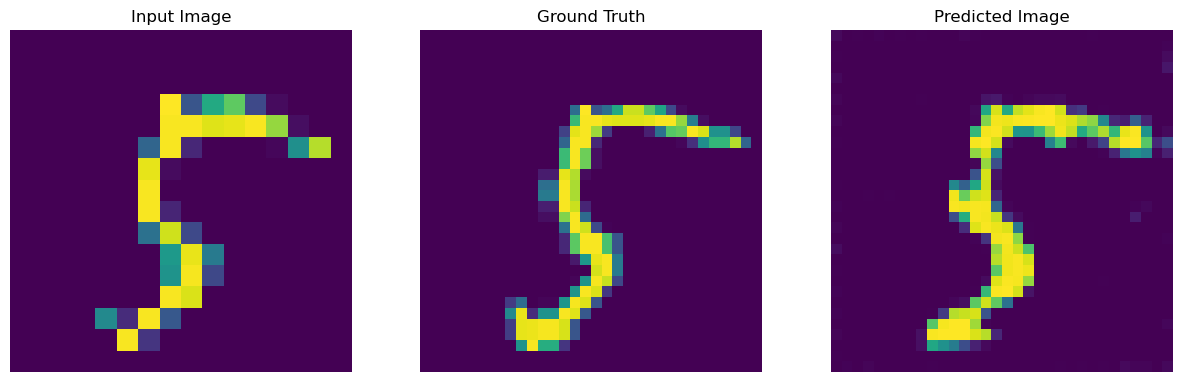

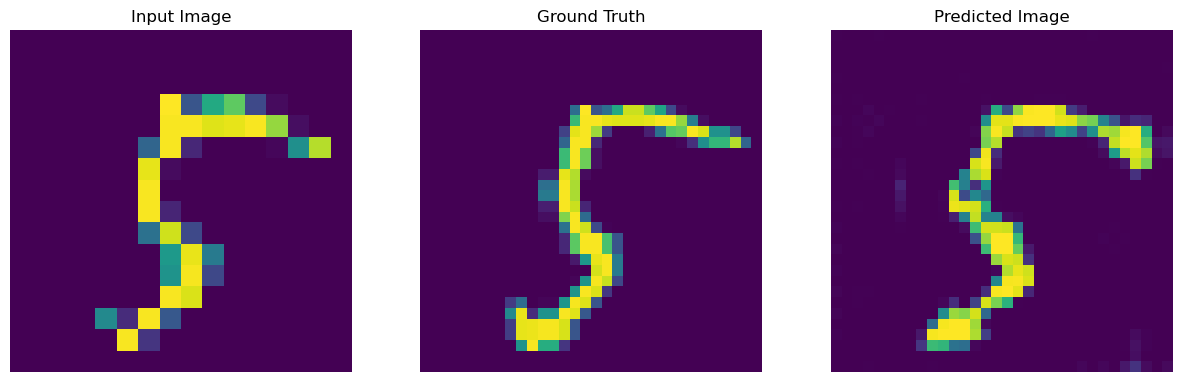

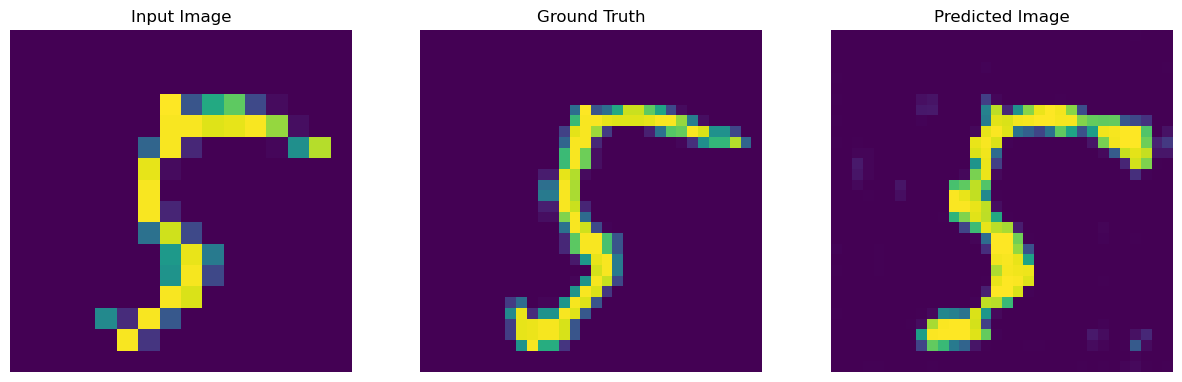

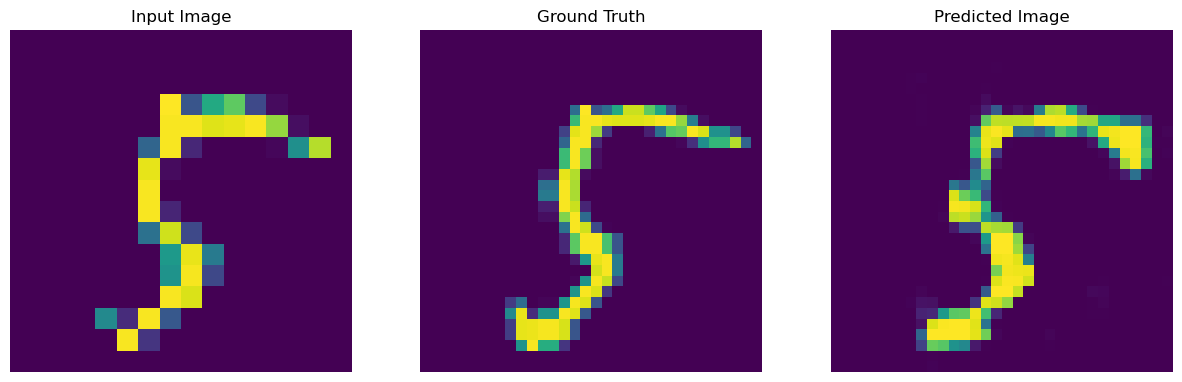

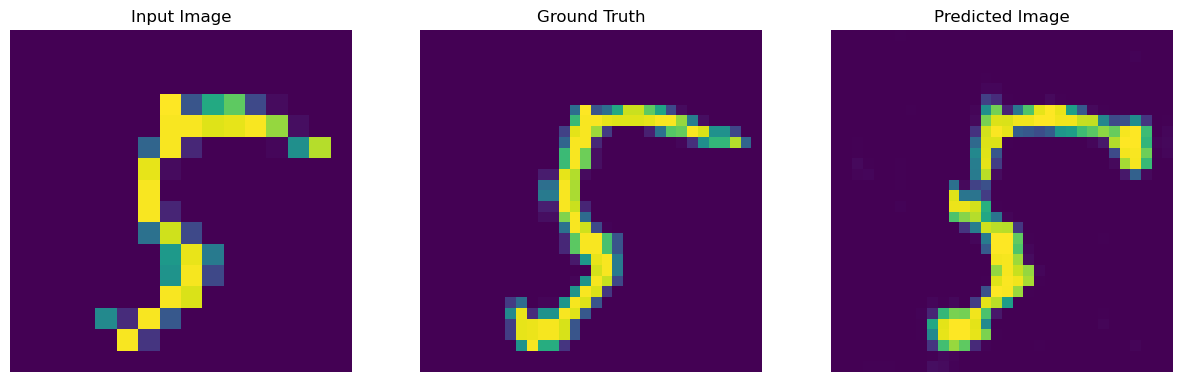

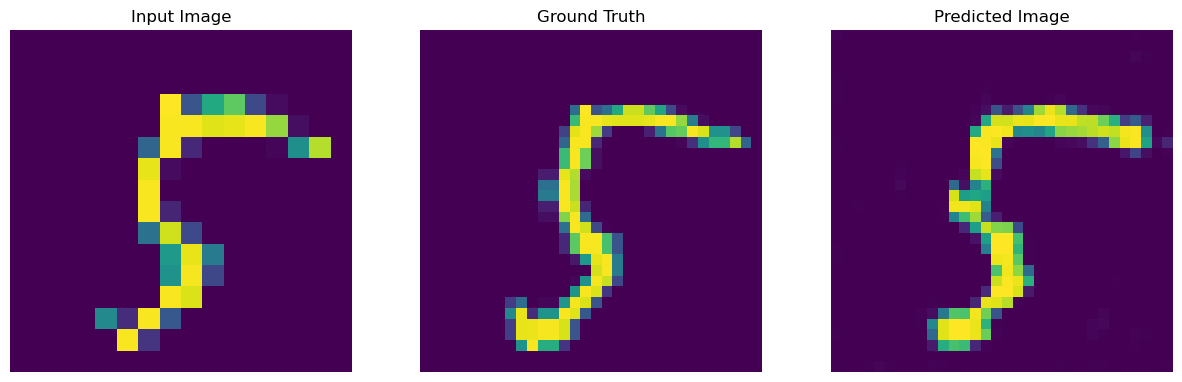

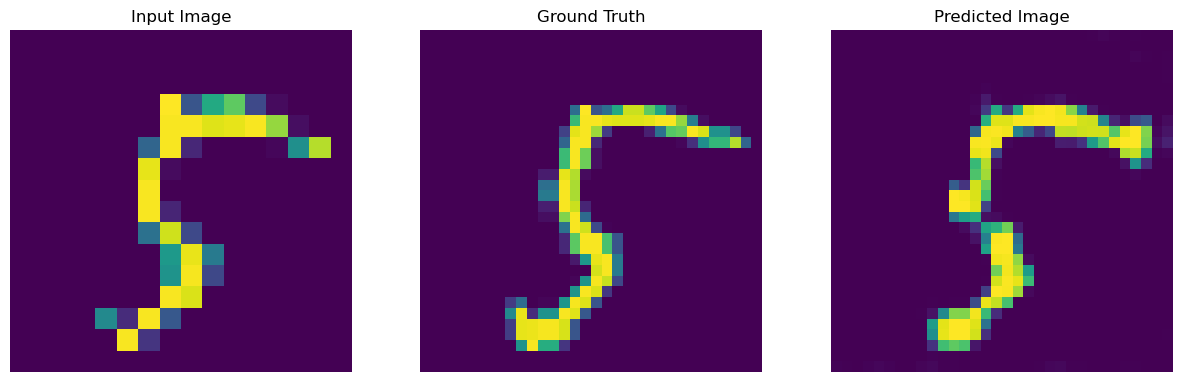

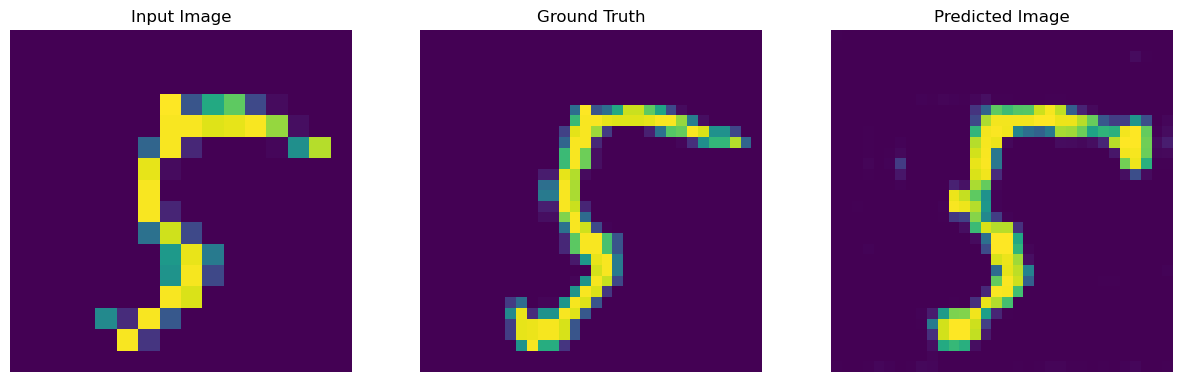

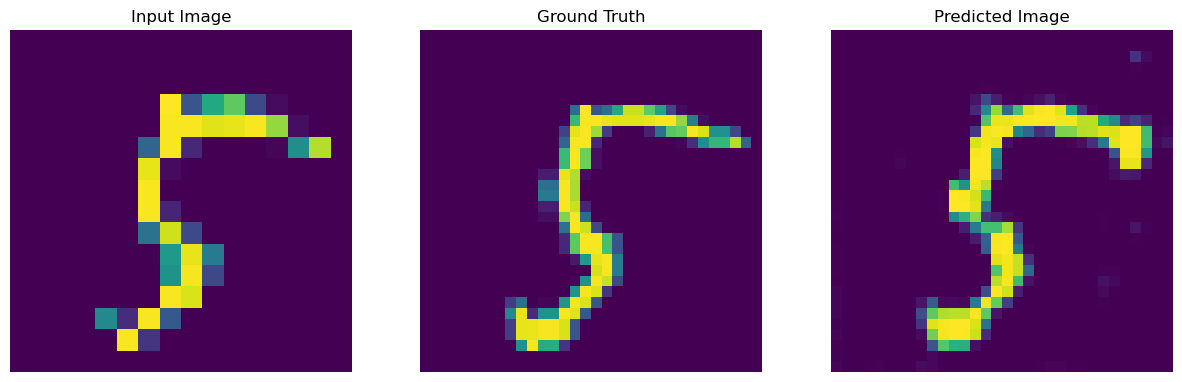

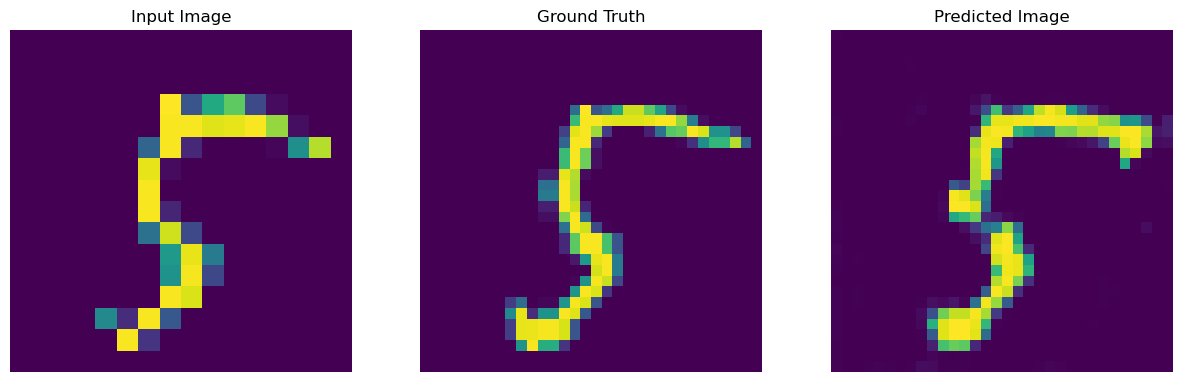

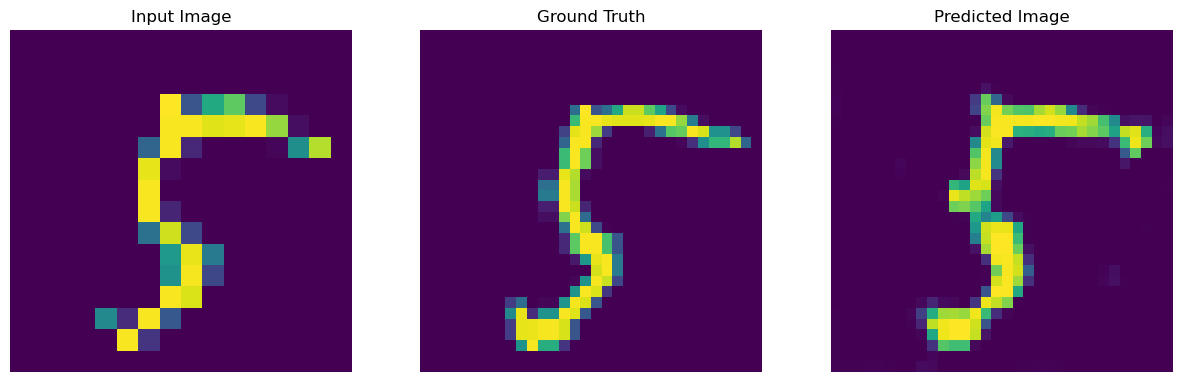

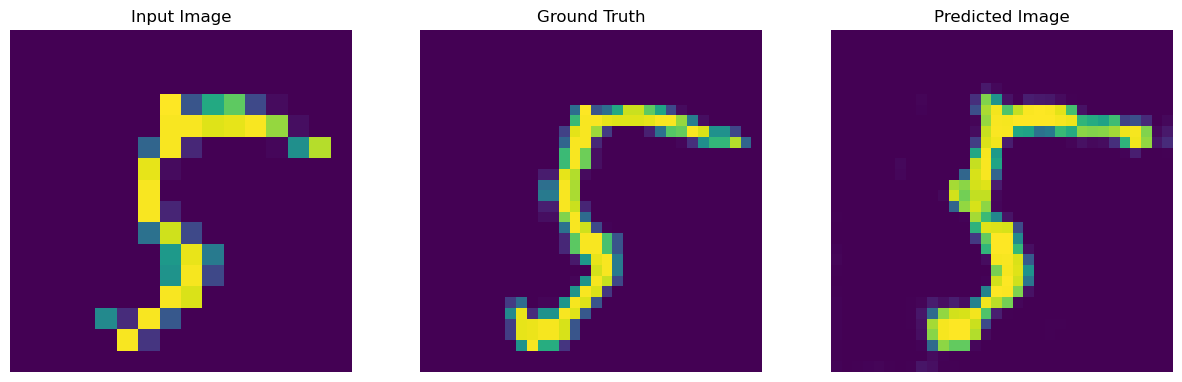

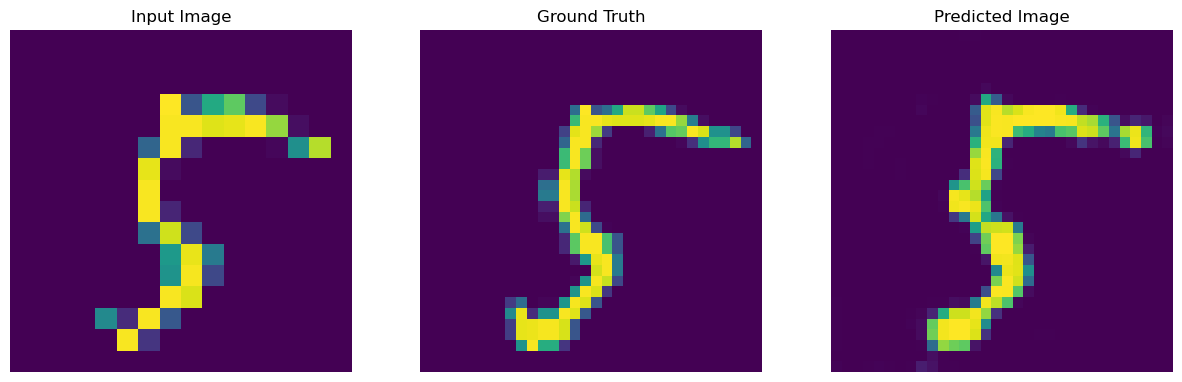

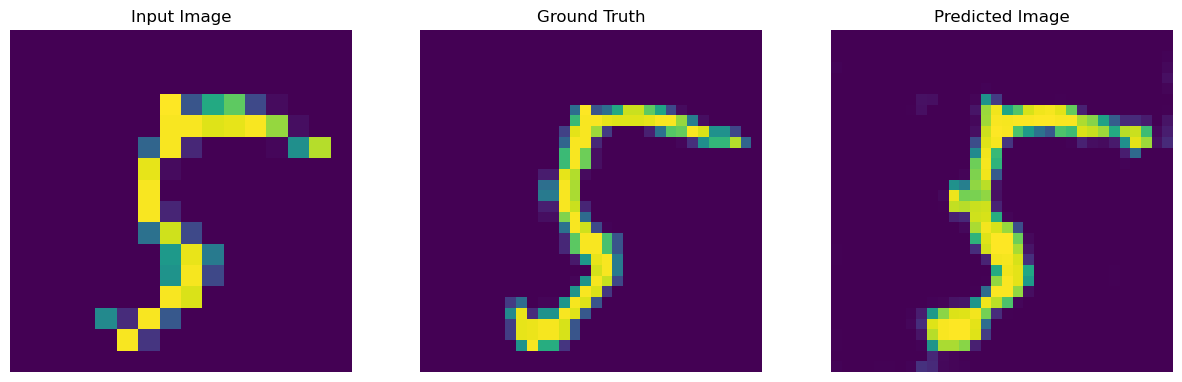

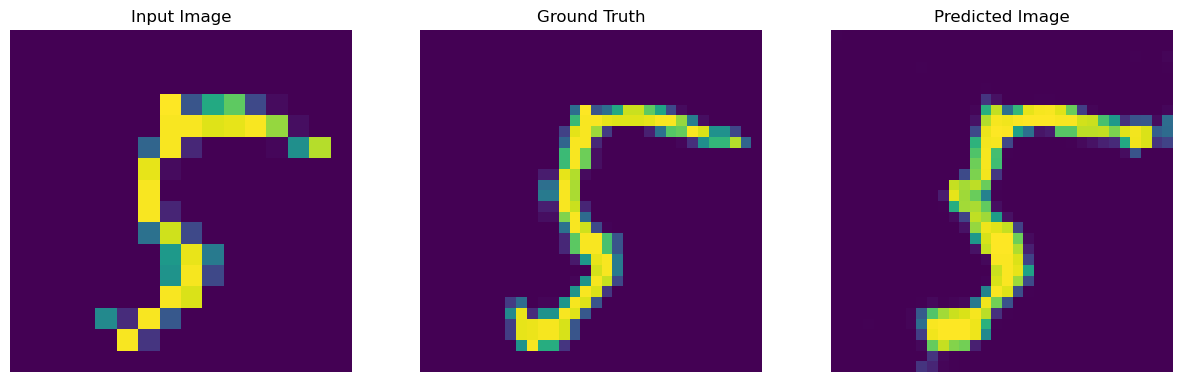

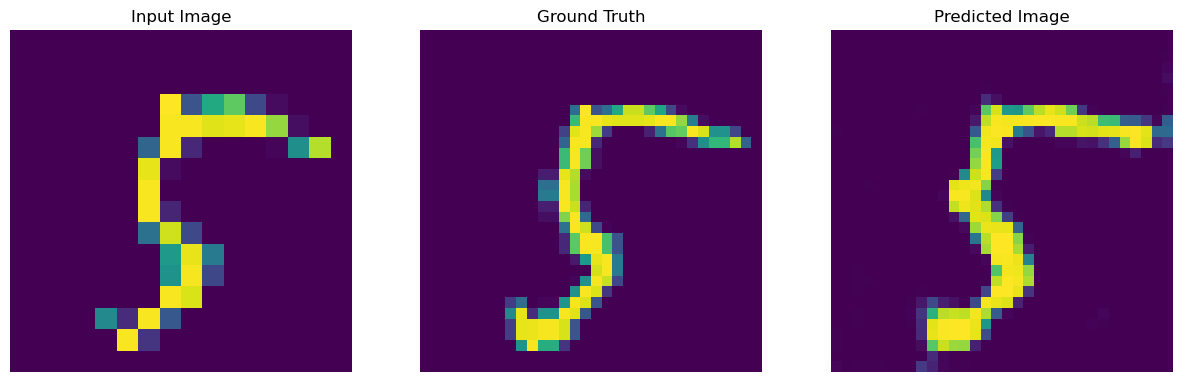

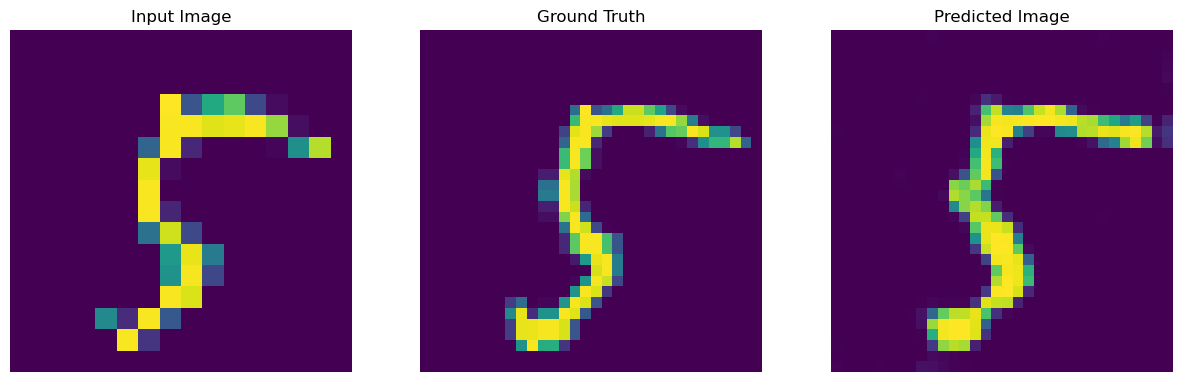

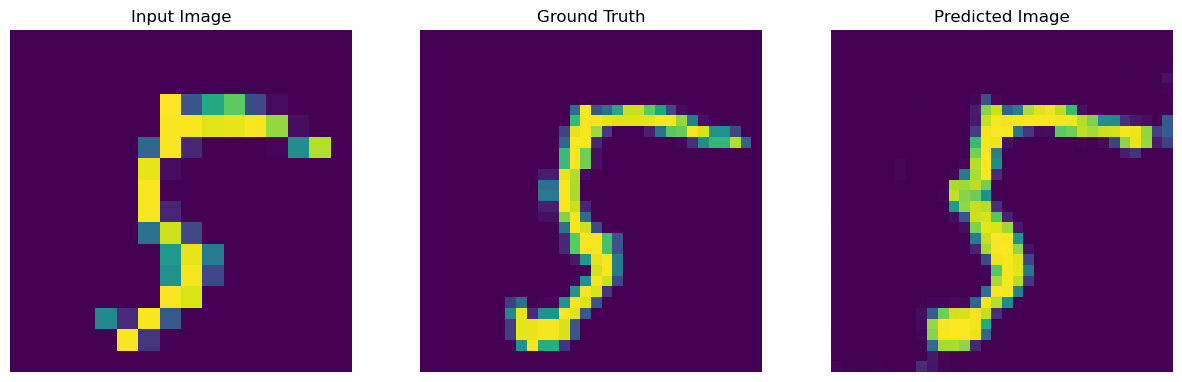

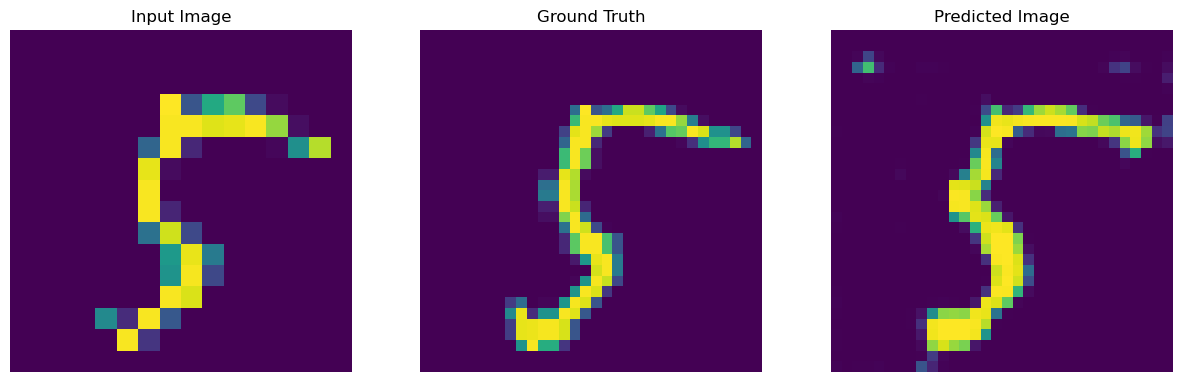

In [27]:
srcgan.fit(train_ds, test_ds, steps=40000)

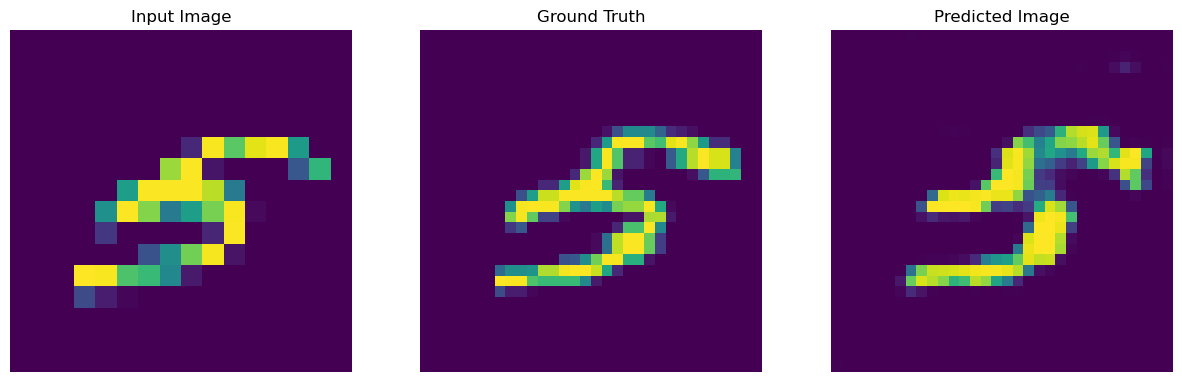

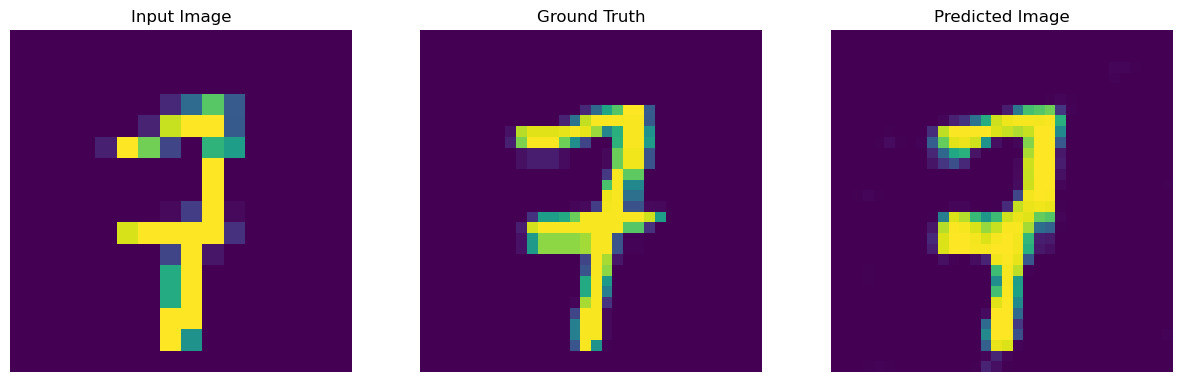

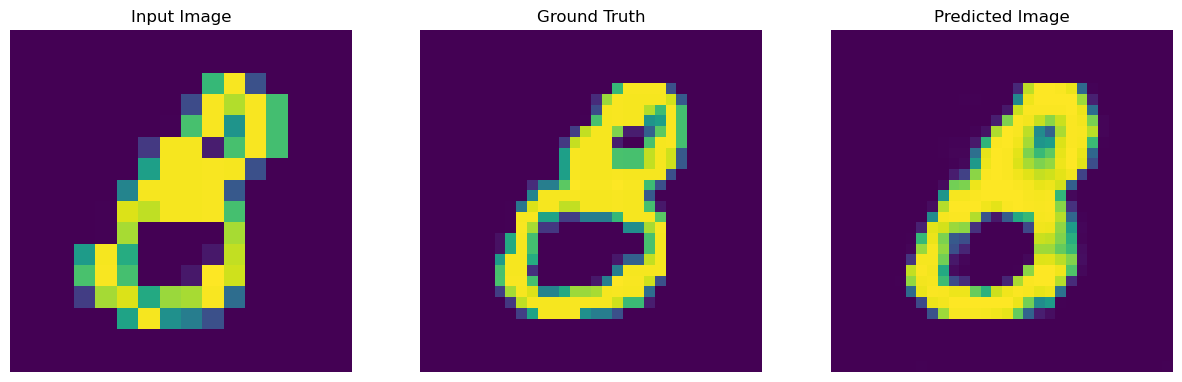

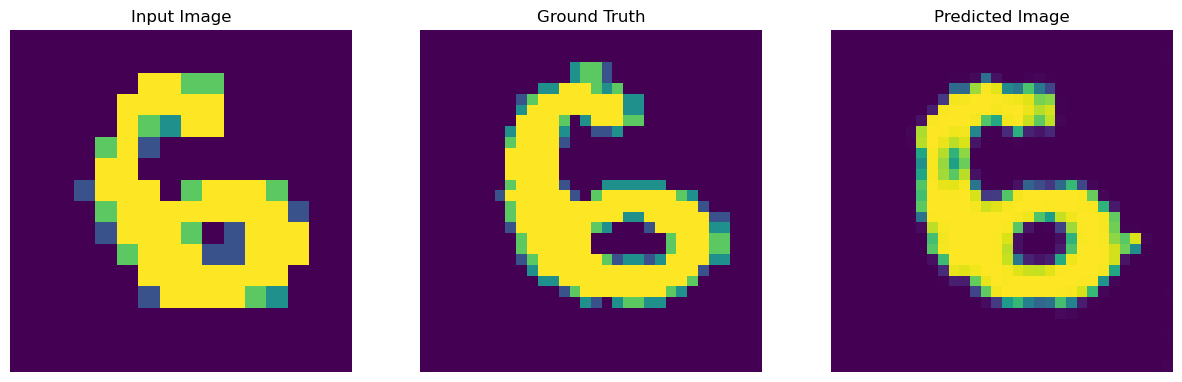

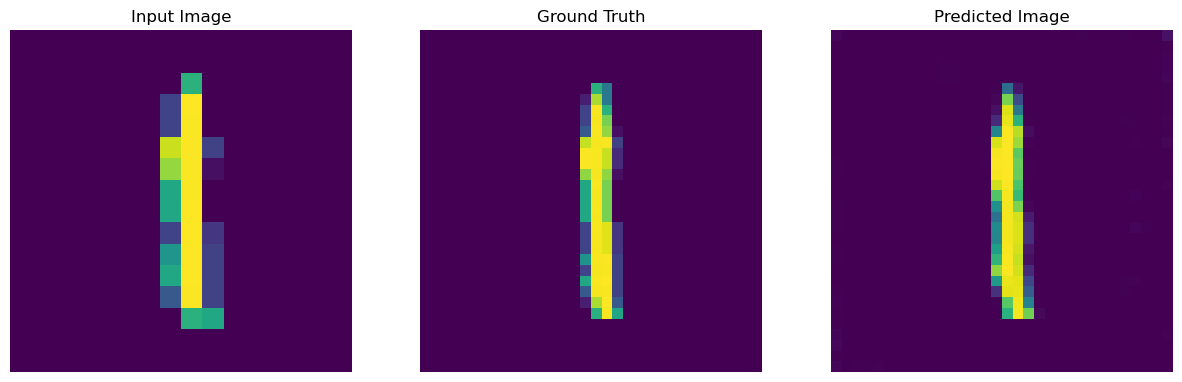

In [28]:
# Run the trained model on a few examples from the test set
for inp, tar in test_ds.take(5):
    srcgan.generate_images(srcgan.generator_, inp, tar)

In [26]:
srcgan.gen_total_loss

[<tf.Tensor 'add:0' shape=() dtype=float16>,
 <tf.Tensor 'add:0' shape=() dtype=float16>]